# Week 5 Assignment - Getting Started GAN, Generating Monet Images

This was part of a Kaggle competition located at kaggle.com/gan-getting-started.

Input data was 4 directories, a photo library and monet library for file formats jpg and tfrec.

There were 300 images in the Monet directory and 7038 images in the photo directory.

The goal of this project is to learn the Monet style from the Monet images and apply them to the photos in the photo directory.  From that we can "monetize" the images for submission.


## Exploratory Data Analysis

Here we will perform some extensive EDA.

### Check the total number of images and look at a few

First step is to see how many images we are working with and to see what the images actually look like in the dataset.  It's always a good idea to familiarize yourself with the data as much as possible.

Number of images: 300
f4413e97bd.jpg
7341d96c1d.jpg
de6f71b00f.jpg
99d94af5dd.jpg
99a51d3e25.jpg


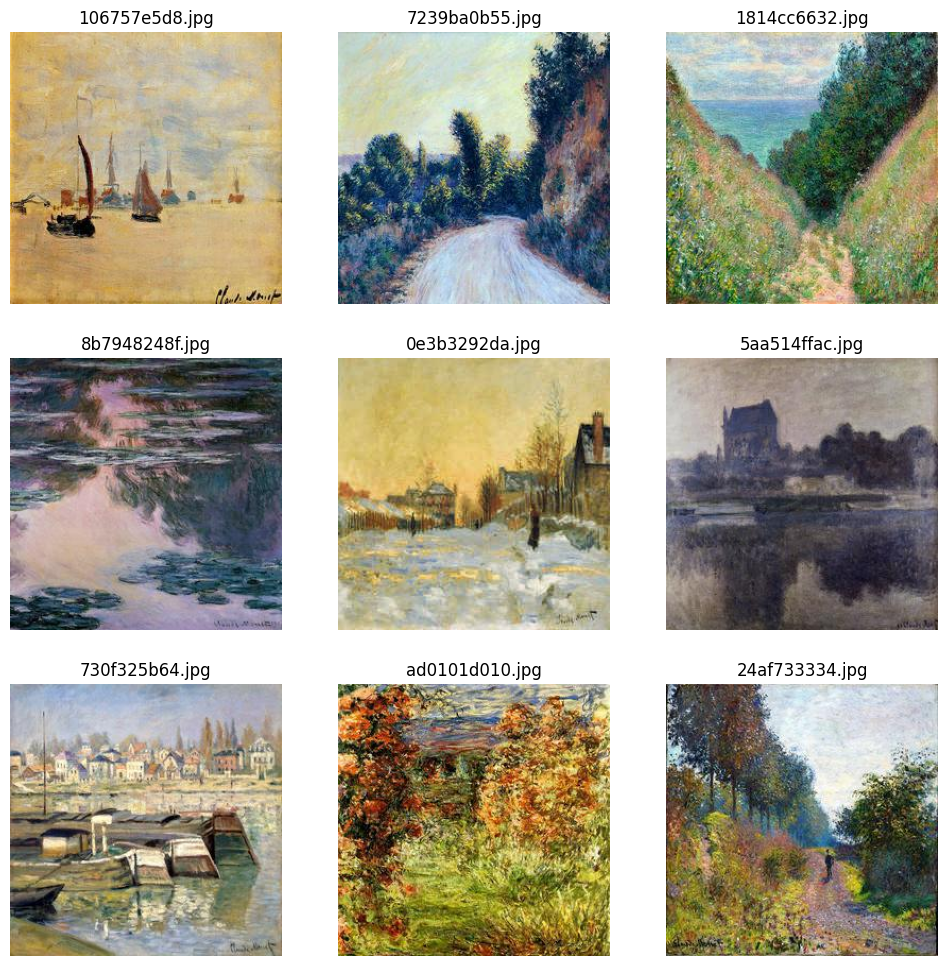

In [17]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Set your local path here
folder = '/kaggle/input/gan-getting-started/monet_jpg'

# List of image files
image_paths = random.sample(os.listdir(folder), 9)

# Get number of images
print('Number of images:', len(os.listdir(folder)))

for img_name in os.listdir(folder)[:5]:
    print(img_name)


# Plot random images
plt.figure(figsize=(12,12))
for idx, img_name in enumerate(image_paths):
    img_path = os.path.join(folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    plt.subplot(3, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)
plt.show()

Great, now that we can see that there are 300 images in the monet_jpg folder and we have viewed some of the images to make sure we're looking at the proper dataset we can move to the next step.

### Image Dimension Analysis

Here we are going to look at the dimensions of the images to make sure that they are all the same and familiarize what we are working with.

Min/Max Width: 256 256
Min/Max Height: 256 256


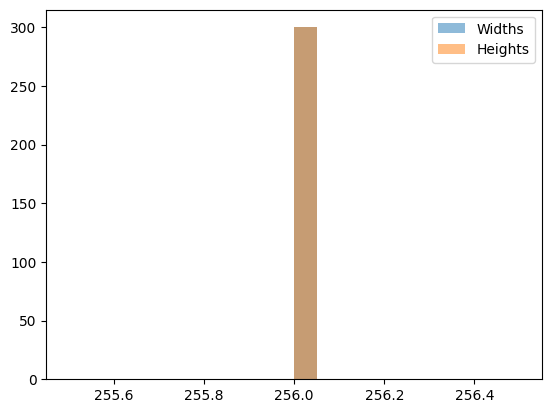

In [18]:
widths = []
heights = []

for img_name in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, img_name))
    h, w, _ = img.shape
    heights.append(h)
    widths.append(w)

print('Min/Max Width:', min(widths), max(widths))
print('Min/Max Height:', min(heights), max(heights))

plt.hist(widths, bins=20, alpha=0.5, label='Widths')
plt.hist(heights, bins=20, alpha=0.5, label='Heights')
plt.legend()
plt.show()

This plot shows that all of our images are of dimensions at 256x256.  This is important because if they were not then we would have to resize to whatever size is most logical.

### Color Distribution Analysis

The purpose of this analysis is to check the color distribution to ensure that there is no missing color channel and that there is proper balance bewteen all of the colors.  If there is strong imbalance then the GAN could perform unexpectedly and we might have to account for it.  This also checks if the images are too skewed towards light and dark images such that the GAN will not bias the results for something not real.

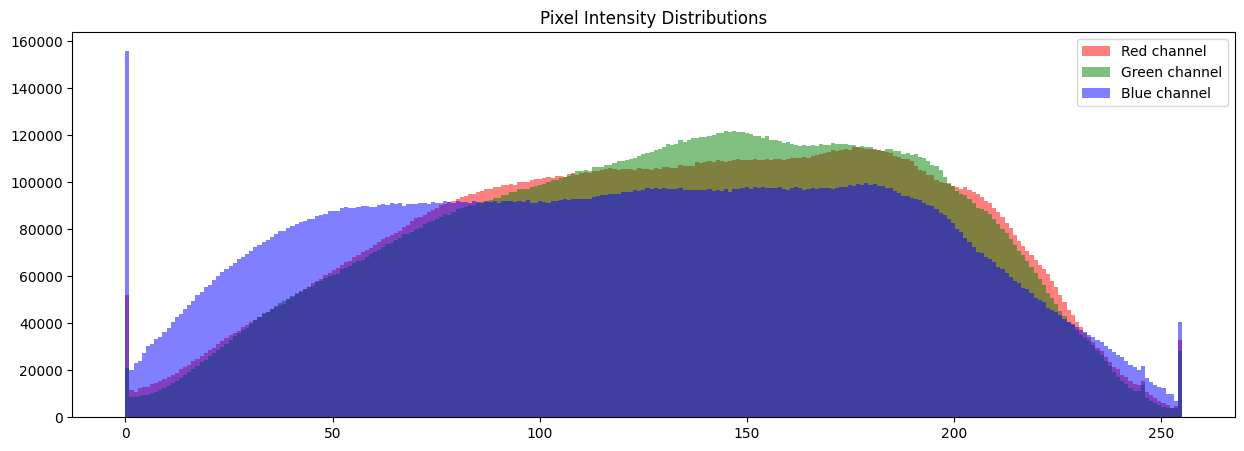

In [19]:
import numpy as np

r_vals = []
g_vals = []
b_vals = []

for img_name in os.listdir(folder)[:500]:  # Limit for speed
    img = cv2.imread(os.path.join(folder, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r_vals.append(img[:,:,0].flatten())
    g_vals.append(img[:,:,1].flatten())
    b_vals.append(img[:,:,2].flatten())

r_vals = np.concatenate(r_vals)
g_vals = np.concatenate(g_vals)
b_vals = np.concatenate(b_vals)

plt.figure(figsize=(15,5))
plt.hist(r_vals, bins=256, color='r', alpha=0.5, label='Red channel')
plt.hist(g_vals, bins=256, color='g', alpha=0.5, label='Green channel')
plt.hist(b_vals, bins=256, color='b', alpha=0.5, label='Blue channel')
plt.legend()
plt.title('Pixel Intensity Distributions')
plt.show()

From this we can see that there is pretty good balance between red/green/blue so we can be confident that no corrections need to be made.

### Image Brightness/Contrast Analysis

Here we continue to check if there are light or dark images.  If there are then we might need to do some color normalizations.

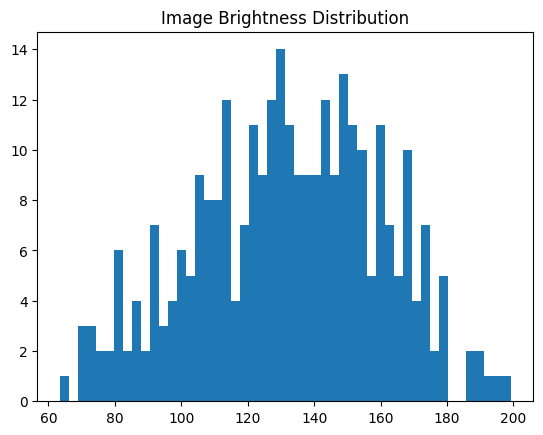

In [20]:
brightness = []

for img_name in os.listdir(folder)[:500]:
    img = cv2.imread(os.path.join(folder, img_name))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brightness.append(np.mean(img_gray))

plt.hist(brightness, bins=50)
plt.title('Image Brightness Distribution')
plt.show()

This plot shows excellent balance in terms of brightness.  The images are not too bright and not too dark.  Here we can be reasonably confident that we do not need to perform color normalization

### t-SNE visualization

Here we just want to look at the distribution of the images using a t-SNE analysis.  Here we are looking for complete random distribution and we should not see any clusters.

Loaded images shape: (300, 64, 64, 3)
Flattened images shape: (300, 12288)
Running PCA...
Running t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.003s...
[t-SNE] Computed neighbors for 300 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 2051.896247
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.907459
[t-SNE] KL divergence after 1900 iterations: 0.895717


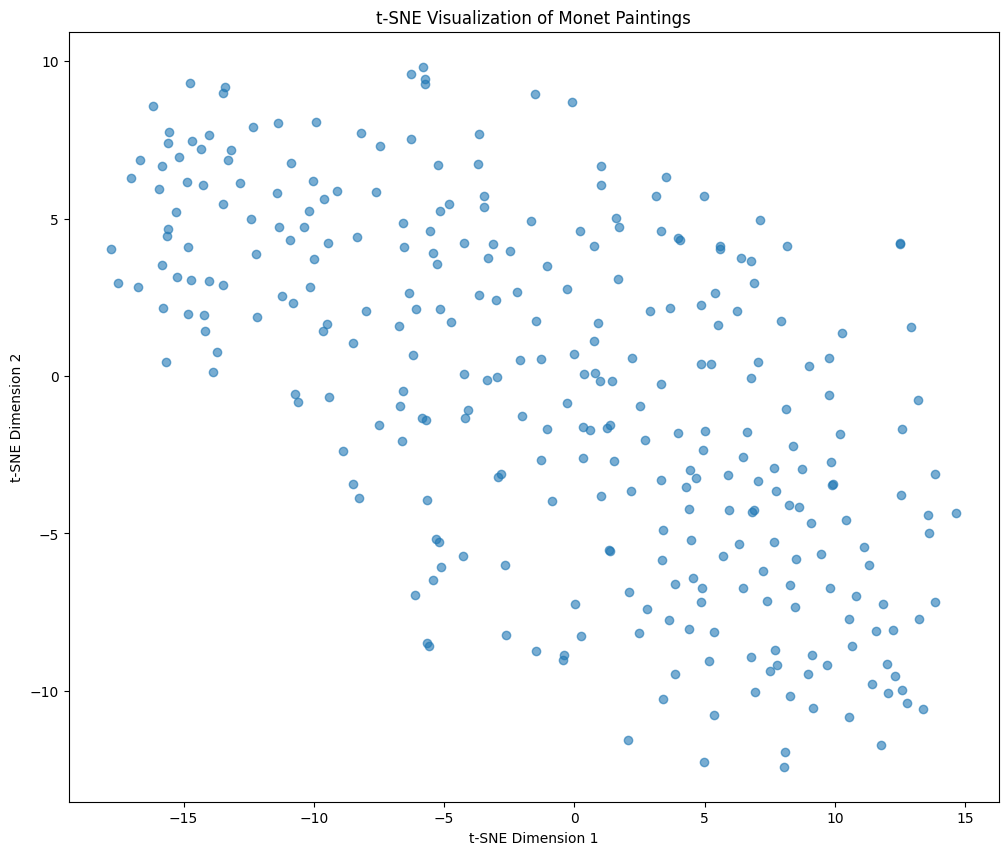

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Settings
IMG_SIZE = 64  # Resize for speed
N_IMAGES = 300  # How many images to visualize (can increase if you want)

# Load images
def load_images_for_tsne(path, n_images=N_IMAGES, img_size=IMG_SIZE):
    image_list = []
    filenames = random.sample(os.listdir(path), n_images)
    for filename in filenames:
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        image_list.append(img)
    return np.array(image_list)

folder = '/kaggle/input/gan-getting-started/monet_jpg'
images = load_images_for_tsne(folder)

print('Loaded images shape:', images.shape)  # (N_IMAGES, 64, 64, 3)

# Flatten images for t-SNE
images_flattened = images.reshape((images.shape[0], -1))  # (N_IMAGES, 64*64*3)

print('Flattened images shape:', images_flattened.shape)

# Optionally: Use PCA first to speed up t-SNE
print('Running PCA...')
pca = PCA(n_components=50)
images_pca = pca.fit_transform(images_flattened)

print('Running t-SNE...')
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000, verbose=1)
tsne_results = tsne.fit_transform(images_pca)

# Plot t-SNE results
plt.figure(figsize=(12, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6)
plt.title('t-SNE Visualization of Monet Paintings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


Good dispersion from within the t-SNE analysis so let's build a model.

## Model Generation

For this I have selected a cycleGAN which should be able to learn the features of the Monet images and run the new images from that.


In [22]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Environment Check
print("="*50)
print("Environment Check:")
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU device:", torch.cuda.get_device_name(0))
else:
    print("WARNING: Training will be slow on CPU!")
print("="*50)

Environment Check:
Torch version: 2.5.1+cu124
CUDA available: True
CUDA version: 12.4
GPU device: Tesla P100-PCIE-16GB


Here is the heavy lifting part of the cycleGAN.  We will run to epochs 40 and save the models at 20, 25, 30, 35, and 40.  We'll compare the outputs and then choose the best looking optimized model.


In [23]:
MONET_JPG_PATH = '/kaggle/input/gan-getting-started/monet_jpg/'
PHOTO_JPG_PATH = '/kaggle/input/gan-getting-started/photo_jpg/'

print('Number of images in Monet directory: ', len(os.listdir(MONET_JPG_PATH)))
print('Number of images in Photo directory: ', len(os.listdir(PHOTO_JPG_PATH)))

Number of images in Monet directory:  300
Number of images in Photo directory:  7038


In [24]:
import tensorflow as tf


monet_ds = tf.keras.preprocessing.image_dataset_from_directory(
    MONET_JPG_PATH, label_mode=None, image_size=(256, 256), batch_size=1
)
monet_ds = monet_ds.map(lambda x: x / 255.0)

photo_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PHOTO_JPG_PATH, label_mode=None, image_size=(256, 256), batch_size=1
)
photo_ds = photo_ds.map(lambda x: x / 255.0)

Found 300 files.
Found 7038 files.


Beefy block of code here that write helper functions as well as defines the generator/discriminator network.  Here we are using the cycleGAN implementation, and will run it for 100 epochs.  The model will save it's checkpoint at every 20 epochs in case we need to go backwards.

In [25]:
import numpy as np
import pandas as pd
import cv2
import math
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Directories
MONET_JPG_PATH = '/kaggle/input/gan-getting-started/monet_jpg/'
PHOTO_JPG_PATH = '/kaggle/input/gan-getting-started/photo_jpg/'

# Load datasets
monet_ds = tf.keras.preprocessing.image_dataset_from_directory(
    MONET_JPG_PATH, label_mode=None, image_size=(256, 256), batch_size=1)
photo_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PHOTO_JPG_PATH, label_mode=None, image_size=(256, 256), batch_size=1)

monet_ds = monet_ds.map(lambda x: x / 255.0)
photo_ds = photo_ds.map(lambda x: x / 255.0)

# Check dataset
for image_batch in monet_ds.take(1):
    print("Monet batch shape:", image_batch.shape)

# Custom InstanceNormalization Layer
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(name='scale', shape=input_shape[-1:], initializer=tf.random_normal_initializer(1., 0.02), trainable=True)
        self.offset = self.add_weight(name='offset', shape=input_shape[-1:], initializer='zeros', trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

# Downsample Block
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_norm:
        if norm_type == 'batchnorm':
            result.add(layers.BatchNormalization())
        else:
            result.add(InstanceNormalization())

    result.add(layers.LeakyReLU())
    return result

# Upsample Block
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if norm_type == 'batchnorm':
        result.add(layers.BatchNormalization())
    else:
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())
    return result

# Generator
def generator(output_channels, norm_type='instancenorm'):
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, norm_type, apply_norm=False),
        downsample(128, 4, norm_type),
        downsample(256, 4, norm_type),
        downsample(512, 4, norm_type),
        downsample(512, 4, norm_type),
        downsample(512, 4, norm_type),
        downsample(512, 4, norm_type),
        downsample(512, 4, norm_type),
    ]

    up_stack = [
        upsample(512, 4, norm_type, apply_dropout=True),
        upsample(512, 4, norm_type, apply_dropout=True),
        upsample(512, 4, norm_type, apply_dropout=True),
        upsample(512, 4, norm_type),
        upsample(256, 4, norm_type),
        upsample(128, 4, norm_type),
        upsample(64, 4, norm_type),
    ]

    last = layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02), activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Discriminator
def discriminator(norm_type='instancenorm', target=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    if target:
        tar = layers.Input(shape=[256, 256, 3], name='target_image')
        x = layers.concatenate([inp, tar])
    else:
        x = inp

    down1 = downsample(64, 4, norm_type, apply_norm=False)(x)
    down2 = downsample(128, 4, norm_type)(down1)
    down3 = downsample(256, 4, norm_type)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    if norm_type == 'batchnorm':
        norm1 = layers.BatchNormalization()(conv)
    else:
        norm1 = InstanceNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    if target:
        return keras.Model(inputs=[inp, tar], outputs=last)
    else:
        return keras.Model(inputs=inp, outputs=last)

# Models
OUTPUT_CHANNELS = 3
generator_g = generator(OUTPUT_CHANNELS)
generator_f = generator(OUTPUT_CHANNELS)

discriminator_x = discriminator(target=False)
discriminator_y = discriminator(target=False)

# Loss Functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 10

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpointing
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Training Step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        # Generator F translates Y -> X
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity Mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator output
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Apply Gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))



Found 300 files.
Found 7038 files.
Monet batch shape: (1, 256, 256, 3)


In [26]:
# Training Loop
EPOCHS = 100

for epoch in range(EPOCHS):
    print(f'Start of epoch {epoch+1}')
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(image_x, image_y)
        if n % 100 == 0:
            print('.', end='')
        n += 1
    print()

    # Save checkpoints every 20 epochs
    if (epoch + 1) % 20 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint at {ckpt_save_path}')


Start of epoch 1


E0000 00:00:1745885435.386356      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_15_1/sequential_8_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1745885437.665378     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


...
Start of epoch 2
...
Start of epoch 3
...
Start of epoch 4
...
Start of epoch 5
...
Start of epoch 6
...
Start of epoch 7
...
Start of epoch 8
...
Start of epoch 9
...
Start of epoch 10
...
Start of epoch 11
...
Start of epoch 12
...
Start of epoch 13
...
Start of epoch 14
...
Start of epoch 15
...
Start of epoch 16
...
Start of epoch 17
...
Start of epoch 18
...
Start of epoch 19
...
Start of epoch 20
...
Saving checkpoint at ./checkpoints/train/ckpt-1
Start of epoch 21
...
Start of epoch 22
...
Start of epoch 23
...
Start of epoch 24
...
Start of epoch 25
...
Start of epoch 26
...
Start of epoch 27
...
Start of epoch 28
...
Start of epoch 29
...
Start of epoch 30
...
Start of epoch 31
...
Start of epoch 32
...
Start of epoch 33
...
Start of epoch 34
...
Start of epoch 35
...
Start of epoch 36
...
Start of epoch 37
...
Start of epoch 38
...
Start of epoch 39
...
Start of epoch 40
...
Saving checkpoint at ./checkpoints/train/ckpt-2
Start of epoch 41
...
Start of epoch 42
...
Start 

In [27]:
import matplotlib.pyplot as plt

def generate_and_plot(original_ds, generator, num_images=1):
    # Take a batch from the dataset
    for real_img_batch in original_ds.take(num_images):
        # real_img_batch: shape (batch_size=1, 256, 256, 3)
        real_img = real_img_batch[0]  # Single image

        # Expand dims to batch format
        input_img = tf.expand_dims(real_img, axis=0)

        # Generate fake image
        fake_img = generator(input_img, training=False)[0]  # Output batch, take 0th image

        # Scale back from [-1, 1] to [0,1] for plotting if needed
        real_img = (real_img + 1) / 2 if tf.reduce_max(real_img) > 1.0 else real_img
        fake_img = (fake_img + 1) / 2

        # Plot
        plt.figure(figsize=(8,4))

        plt.subplot(1,2,1)
        plt.imshow(real_img.numpy())
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(fake_img.numpy())
        plt.title('Generated')
        plt.axis('off')

        plt.show()

        break  # Only generate one pair unless you remove this


Generation code written above, and called below to input one of the photos and output a Monet style photo image.

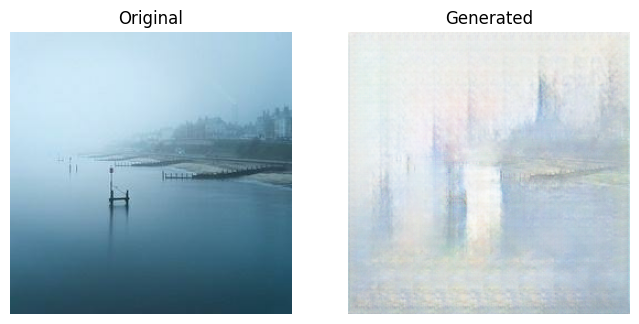

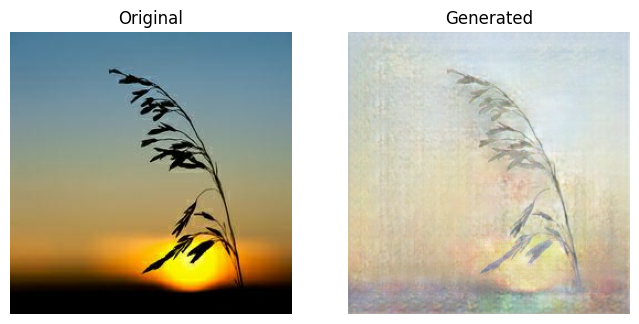

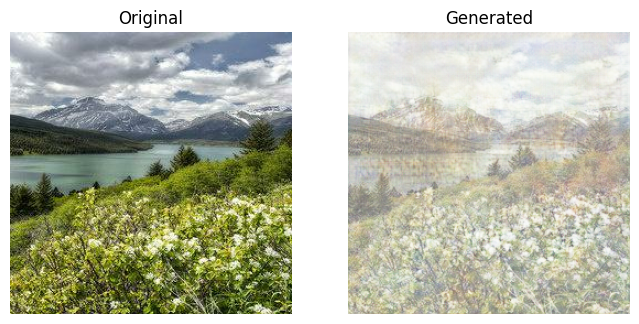

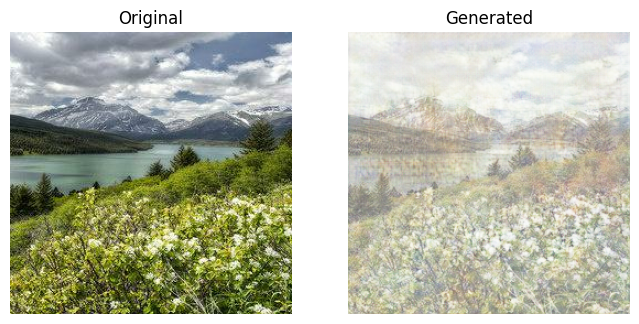

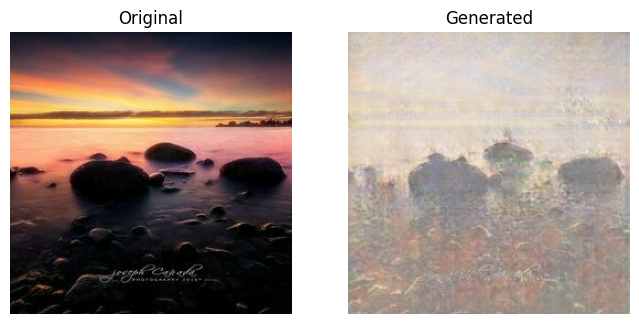

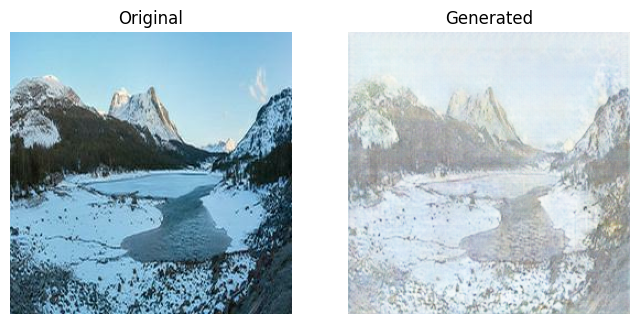

In [28]:
generate_and_plot(photo_ds, generator_g, num_images=1)
generate_and_plot(photo_ds, generator_g, num_images=1)
generate_and_plot(photo_ds, generator_g, num_images=1)
generate_and_plot(photo_ds, generator_g, num_images=1)
generate_and_plot(photo_ds, generator_g, num_images=1)
generate_and_plot(photo_ds, generator_g, num_images=1)



This reaonsably looks like we have been able to monet-ize the original image with some painted brushstrokes.  There still is missing a bit of color from within the synthetically generated image, but it's good enough for now.

In [29]:
import zipfile
import io
import tensorflow as tf

def generate_all_to_zip(original_ds, generator, zip_filename="images.zip"):
    # Create an in-memory bytes buffer
    zip_buffer = io.BytesIO()
    zipf = zipfile.ZipFile(zip_buffer, "w", zipfile.ZIP_DEFLATED)

    # Iterate through the dataset
    img_idx = 0
    for real_img_batch in original_ds:
        real_img = real_img_batch[0]  # batch size 1

        # Expand dims to batch format
        input_img = tf.expand_dims(real_img, axis=0)

        # Generate fake image
        fake_img = generator(input_img, training=False)[0]

        # Scale from [-1,1] to [0,255] if needed
        if tf.reduce_max(fake_img) <= 1.0:
            fake_img = (fake_img + 1) * 127.5
        
        fake_img = tf.cast(fake_img, tf.uint8)

        # Encode to JPEG
        encoded_img = tf.io.encode_jpeg(fake_img)

        # Write into the zip
        filename = f"image_{img_idx:05d}.jpg"  # e.g., image_00001.jpg
        zipf.writestr(filename, encoded_img.numpy())

        img_idx += 1

    # Close the zip
    zipf.close()

    # Save the zip file to disk
    with open(zip_filename, 'wb') as f:
        f.write(zip_buffer.getvalue())

    print(f"Saved {img_idx} images into {zip_filename}")


In [ ]:
# Translate ALL photos ➔ Monet and save them into images.zip
generate_all_to_zip(photo_ds, generator_g, zip_filename="images.zip")



## Results

Here we will make our submission file and run some basic metrics on the generated images.  We will run inception score and FID.

In [ ]:
!mkdir -p /kaggle/working/submit_images
!cp /kaggle/working/images.zip /kaggle/working/submit_images/

In [ ]:
# Rebuild the folder cleanly
!rm -rf /kaggle/working/submit_images
!mkdir -p /kaggle/working/submit_images

# Copy the file fresh
!cp /kaggle/working/images.zip /kaggle/working/submit_images/

# Show contents
!ls /kaggle/working/submit_images/

In [1]:
import tensorflow as tf
import numpy as np
import os
from scipy import linalg
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

2025-04-29 12:10:50.556798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745928650.808478      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745928650.881795      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
import os
from PIL import Image

def load_real_images_from_folder(folder_path, num_images=20, target_size=(299, 299)):
    image_paths = sorted(os.listdir(folder_path))[:num_images]
    imgs = []

    for fname in tqdm(image_paths, desc="Loading real images"):
        img_path = os.path.join(folder_path, fname)
        img = Image.open(img_path).convert("RGB")
        img = img.resize(target_size)
        img = np.array(img)
        img = preprocess_input(img)  # Preprocess for InceptionV3
        imgs.append(img)

    return np.stack(imgs)

def load_images_from_zip(zip_path, num_images=20, target_size=(299, 299)):
    from zipfile import ZipFile
    imgs = []

    with ZipFile(zip_path, 'r') as zipf:
        filenames = sorted(zipf.namelist())[:num_images]
        for fname in tqdm(filenames, desc="Loading images"):
            with zipf.open(fname) as file:
                img = tf.io.decode_jpeg(file.read(), channels=3)
                img = tf.image.resize(img, target_size)
                img = preprocess_input(img)  # [-1,1] scaled for Inception
                imgs.append(img)

    return np.stack(imgs)

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_inception_score(preds, splits=5):
    scores = []
    N = preds.shape[0]
    split_size = N // splits
    for i in range(splits):
        part = preds[i * split_size : (i+1) * split_size]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean(np.sum(part * (np.log(part) - np.log(py)), axis=1))))
    return np.mean(scores), np.std(scores)

In [11]:
# Load 20 real Monet images
real_images = load_real_images_from_folder(
    "/kaggle/input/gan-getting-started/monet_jpg", num_images=20
)

# Load 20 generated images from your zip
generated_images = load_images_from_zip("images.zip", num_images=20)


# Load InceptionV3 model (already done earlier if not, do this)
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Compute activations
act_real = inception_model.predict(real_images, batch_size=10, verbose=1)
act_generated = inception_model.predict(generated_images, batch_size=10, verbose=1)

# FID
fid_score = calculate_fid(act_real, act_generated)

# IS
softmax_model = InceptionV3(include_top=True, weights='imagenet', input_shape=(299,299,3))
preds = softmax_model.predict(generated_images, batch_size=10, verbose=1)
is_score, is_std = calculate_inception_score(preds)

# Results
print(f"✅ Final FID: {fid_score:.2f}")
print(f"✅ Final Inception Score: {is_score:.2f} ± {is_std:.2f}")

Loading images: 100%|██████████| 20/20 [00:01<00:00, 11.39it/s]


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


I0000 00:00:1745929236.399462     101 service.cc:148] XLA service 0x7806f4003250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745929236.400538     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745929237.382748     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


I0000 00:00:1745929242.773642     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
✅ Final FID: 228.68
✅ Final Inception Score: 2.36 ± 0.24


## Conclusions

We have generated a model that is able to take in a directory of Monet images and apply the artistic style to standard photos.  The model is based on a cycleGAN structure with some helping functions to up and downsample the images to advance the generation.

Ultimately, our model had a final FID score of 228.68 which isn't great for generated images.  We would like this to be as close to 0 as possible.  However, the inception score is a bit better, but still not great.  We would need to work on the imaging a bit more to make sure these numbers are maximixed.

Overall, our images pass the "eye" manual test where we can see the images themselves, but the statistical root of the images isn't fooling the machines yet.  Part of it is as you can see the images have lost quite a bit of color.  When this happens you lose a bit of contrast and it looks a bit more noise than anything else.  Another reason why these stats are so bad is that as you can see in the first image, there isn't a lot of diversity in the original image.  So there is nothing to apply Monet style to.  A large lake isn't something that is going to look like a blob either way whether you apply Monet style or someone else.  I guess you could call it the artistic style in general.  The Monet style isn't realism, it's impressionist so you would expect a bit of this to occur.

However, it is clear the Monet style is coming through.  Perhaps we could retrain the model with more epochs to see if it converges even more after say 100 more epochs.  It is on the right track, but you can't go too far otherwise you'll overfit the model.  It might also be wise to train this on multiple artistic styles and see if the style comes through on multiple data sources.  That could give a proper comparision on how the model learns from scratch.